# Observations Notebook

The following notebook is used to generate information about a an observation, including the stellar catalog matching and extraction of postage stamp cubes (PSC).

The notebook takes an `images_directory` as the start parameter and produces a series of plots, parquet files, and links to raw data.

In [1]:
images_directory = '/var/panoptes/images/temp'
service_account_key_path = '/keys/panoptes-exp-ab0a5c6c3108.json'

In [2]:
import os
# import sys
import glob

# import numpy as np
# import holoviews as hv
# from holoviews import opts
# import pandas as pd
# import hvplot.pandas
# from astropy.coordinates import SkyCoord

# from contextlib import suppress
# from google.cloud import bigquery

# from panoptes.pipeline.utils.metadata import search_observations, get_metadata
# from panoptes.pipeline.utils import sources
# from panoptes.pipeline.utils import processing
# from panoptes.utils.images import fits as fits_utils
# from panoptes.utils.images import crop_data
# from panoptes.utils.logging import logger

# from tqdm import tqdm

# import seaborn as sb

# hv.extension('bokeh')

# # Set up the logger for notebook viewing
# logger.enable('panoptes')

# # Holoviews styling options
# opts.defaults(
#     opts.Image(cmap='viridis', tools=['hover'], width=400, height=400),
#     opts.Labels(text_color='white', text_font_size='8pt', text_align='left', text_baseline='bottom'),
# )

## BigQuery Authentication

> TODO

In [4]:
bq_client = bigquery.Client.from_service_account_json(service_account_key_path)

NameError: name 'bigquery' is not defined

## Gather files

Get all the FITS files in the directory

In [3]:
fits_files = glob.glob(f'{images_directory}/*.fits*')
print(f'Found {len(fits_files) in {images_directory=}}')

SyntaxError: invalid syntax (<fstring>, line 1)

## Plate-solve and catalog match

In [11]:
wcs0 = fits_utils.getwcs(fits_files[0])
wcs0

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 278.648603129  35.6537029884  
CRPIX : 2604.5  1738.5  
CD1_1 CD1_2  : -3.5221754806e-06  -0.00285988359294  
CD2_1 CD2_2  : -0.0028594092486  1.67799808995e-06  
NAXIS : 5208  3476

#### Lookup catalog stars

This will use the WCS from the first image to find all the stars listed in the PANOPTES catalog. 

This can be a large number of stars and goes to $4 <= V_{mag} < 17$ so includes many sources that will not appear in an individual image.

In [12]:
catalog_stars_csv = f'{sequence_id}/catalog-stars.parquet'

try:
    catalog_stars = pd.read_parquet(catalog_stars_csv).convert_dtypes()
except FileNotFoundError:
    catalog_stars = sources.get_stars_from_wcs(wcs0, bq_client=bq_client)
    catalog_stars.to_parquet(catalog_stars_csv, index=False)    

In [13]:
catalog_stars

,picid,twomass,gaia,catalog_ra,catalog_dec,catalog_vmag,catalog_vmag_bin,catalog_vmag_err
0,28570131,18494590+3248463,2090563996916353024,282.44133,32.81282,5.91835,5,0.023
1,237184192,18534355+3658182,2093922180304989568,283.43150,36.97172,5.58373,5,0.023
2,321850466,18195170+3603523,4605754569811634944,274.96545,36.06454,4.31866,4,0.023
3,27901267,18363734+3328085,2091218000175889024,279.15560,33.46904,5.40887,5,0.023
4,237195876,18543027+3653551,2093931938470745728,283.62619,36.89862,4.34137,4,0.023
...,...,...,...,...,...,...,...,...
502230,180844293,18125896+3227393,4592850907506396672,273.24567,32.46094,15.35300,15,0.035
502231,23392905,18212143+3111159,4591739060733752192,275.33934,31.18776,15.36500,15,0.035
502232,336320357,18464324+3749261,2096890342002460928,281.68020,37.82392,15.79200,15,0.035
502233,24118623,18273182+3124370,4591608321929478144,276.88260,31.41033,15.26700,15,0.035


#### Lookup point sources in image

Now we want to do a source extraction on the individual images to see what stars are detected. We can match this with the catalog stars above.

In [5]:
point_sources = list()

csv_dir = f'{sequence_id}/csv'
point_sources_csv = f'{sequence_id}/point-sources.parquet'
os.makedirs(csv_dir, exist_ok=True)

if not os.path.exists(point_sources_csv):
    for fits_file in tqdm(fits_files):
        image_id = fits_utils.getval(fits_file, 'IMAGEID')
        csv_filename = f'{csv_dir}/{image_id}.parquet'

        if os.path.exists(csv_filename):
            continue
            
        if not os.path.exists(fits_file):
            fits_file = fits_file.replace('.fz', '')

        sources_found = sources.lookup_point_sources(
            fits_file,
            catalog_match=True,
            catalog_stars=catalog_stars,
            bq_client=bq_client
        )
        processing.get_postage_stamps(sources_found, 
                                      fits_file, 
                                      output_fn=f'{csv_dir}/{image_id}-stamps.csv')
        sources_found.to_parquet(csv_filename, index=False)
        point_sources.append(sources_found)

    obs_sources_df = pd.concat(point_sources)
    obs_sources_df.to_parquet(point_sources_csv, index=False)
else:
    print(f'Loading local point sources csv')
    obs_sources_df = pd.read_parquet(point_sources_csv).convert_dtypes()

Loading local point sources csv


In [54]:
# Random example
random = obs_sources_dfb.query('catalog_vmag <= 13').sample(1).T
random

,824054
picid,157766779
unit_id,PAN001
camera_id,14d3bd
time,2020-05-20 12:02:20
gaia,2098002502313274624
...,...
pixel_95,2172
pixel_96,2123
pixel_97,2209
pixel_98,2129


In [55]:
random.T.catalog_vmag

824054    11.822
Name: catalog_vmag, dtype: object

In [56]:
picid = random.T.iloc[0].picid
picid

157766779

### Make PSC

In [57]:
target_df = obs_sources_df.query('picid==@picid')

<AxesSubplot:xlabel='catalog_sep_arcsec', ylabel='Count'>

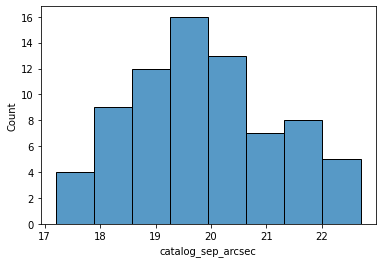

In [58]:
sb.histplot(target_df.catalog_sep_arcsec)

In [100]:
target_df

,picid,unit_id,camera_id,time,gaia,twomass,status,catalog_dec,catalog_ra,catalog_sep_arcsec,...,pixel_90,pixel_91,pixel_92,pixel_93,pixel_94,pixel_95,pixel_96,pixel_97,pixel_98,pixel_99
8654,157766779,PAN001,14d3bd,2020-05-20 09:41:52,2098002502313274624,18395316+3912200,matched,39.20553,279.97154,22.363846,...,2122,2167,2133,2154,2122,2196,2142,2209,2168,2301
28505,157766779,PAN001,14d3bd,2020-05-20 09:45:53,2098002502313274624,18395316+3912200,matched,39.20553,279.97154,19.765278,...,2115,2174,2127,2166,2119,2191,2147,2210,2158,2316
49243,157766779,PAN001,14d3bd,2020-05-20 09:49:45,2098002502313274624,18395316+3912200,matched,39.20553,279.97154,21.332983,...,2101,2166,2124,2172,2119,2184,2108,2216,2120,2243
70044,157766779,PAN001,14d3bd,2020-05-20 09:53:37,2098002502313274624,18395316+3912200,matched,39.20553,279.97154,19.771267,...,2117,2196,2132,2170,2107,2190,2146,2209,2170,2252
90195,157766779,PAN001,14d3bd,2020-05-20 09:57:24,2098002502313274624,18395316+3912200,matched,39.20553,279.97154,21.390723,...,2112,2166,2122,2188,2119,2181,2150,2228,2161,2272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1664645,157766779,PAN001,14d3bd,2020-05-20 14:19:24,2098002502313274624,18395316+3912200,matched,39.20553,279.97154,18.002897,...,2124,2151,2122,2148,2110,2152,2138,2176,2126,2214
1692393,157766779,PAN001,14d3bd,2020-05-20 14:23:22,2098002502313274624,18395316+3912200,matched,39.20553,279.97154,19.298937,...,2118,2129,2107,2146,2113,2169,2124,2180,2133,2210
1719955,157766779,PAN001,14d3bd,2020-05-20 14:31:18,2098002502313274624,18395316+3912200,matched,39.20553,279.97154,20.350830,...,2118,2162,2132,2146,2105,2155,2122,2178,2128,2190
1744846,157766779,PAN001,14d3bd,2020-05-20 14:35:44,2098002502313274624,18395316+3912200,matched,39.20553,279.97154,17.902591,...,2110,2169,2106,2191,2119,2176,2126,2203,2149,2224


In [59]:
# obs_sources_df['image_id'] = obs_sources_df['unit_id'] + "_" + obs_sources_df['camera_id'] + "_" + obs_sources_df['time']

In [60]:
# obs_sources_df2 = obs_sources_df.merge(images_df, on='image_id')

In [61]:
# stamps = list()
# for fn in tqdm(glob.glob('PAN001_14d3bd_20200520T093913/csv/*-stamps*')):
#     stamps.append(pd.read_csv(fn).convert_dtypes())
    
# stamps = pd.concat(stamps)

# obs_sources_df = obs_sources_df.merge(stamps, how='outer')

# obs_sources_df.to_parquet(point_sources_csv)

In [62]:
obs_sources_df.time = pd.to_datetime(obs_sources_df.time)

In [63]:
(obs_sources_df.groupby('time').mean().measured_background - 2048).hvplot()

:Curve   [time]   (measured_background)

In [64]:
psc0 = processing.get_psc(picid, obs_sources_df)

In [65]:
hv.Image(psc0[-11].reshape(10, 10))

:Image   [x,y]   (z)

In [70]:
obs_sources_df.columns

Index(['picid', 'unit_id', 'camera_id', 'time', 'gaia', 'twomass', 'status',
       'catalog_dec', 'catalog_ra', 'catalog_sep_arcsec',
       ...
       'pixel_90', 'pixel_91', 'pixel_92', 'pixel_93', 'pixel_94', 'pixel_95',
       'pixel_96', 'pixel_97', 'pixel_98', 'pixel_99'],
      dtype='object', length=138)

In [82]:
kdims = ['picid', 'unit_id', 'camera_id', 'time', 'gaia', 'twomass', 'catalog_ra', 'catalog_dec']

In [84]:
vdims = list(set(obs_sources_df.columns.to_list()).difference(kdims))

In [89]:
ds = hv.Dataset(target_df, kdims, vdims)

In [99]:
ds.to(hv.Curve, 'time', 'measured_mag_best').opts(width=600)

:HoloMap   [picid,unit_id,camera_id,gaia,twomass,catalog_ra,catalog_dec]
   :Curve   [time]   (measured_mag_best)